# Reddit Web Scraping

# Goal
Reddit is a huge exosystem brimming with data that is readily available. As a data scientist in financial industry, I would like to know how popular a certain stock or options product is in social media. I would take the advantage of Reddit API access to extract posts and comments by keyword. The results from the reddit web scraping can be further used as a feature and applied into another machine learning project to analyze the key drivers of options volume growth.

Objectives:
* Demonstrate how to create a Reddit API account.
* Demonstrade how to extract posts and comments through pre-defined keywords by accessing Reddit API.
    * understand how many times per day people talk about SPX 0DTE options in Reddit. This will become a feature in another machine learning project to see if the popularity in social media can be a key driver of volume growth for SPX 0DTE options . 

# Get Reddit API Access

First, we need access. I will show how to follow the [Praw Documentation](https://praw.readthedocs.io/en/stable/getting_started/quick_start.html) to create API access.

1. Go to [App Preferences](https://www.reddit.com/prefs/apps) and click **create another app** at the bottom
2. Fill out the required details, make sure to select **script** — and click create app.
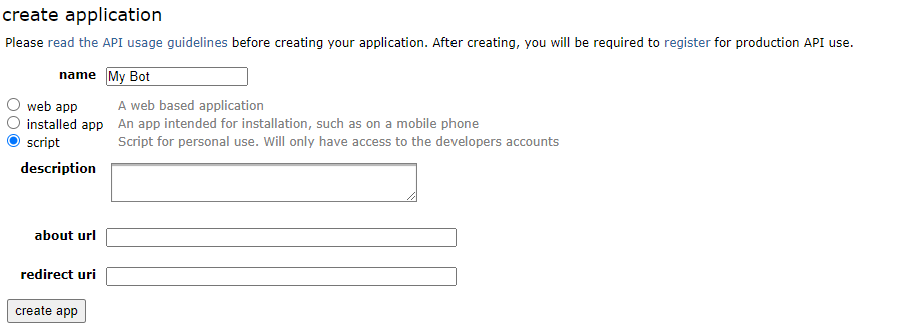

3. Other relevant resources.
    * [Reddit API Wiki](https://github.com/reddit-archive/reddit/wiki/API)


In [1]:
# pip install praw

In [3]:
import pandas as pd
import praw
import re
import requests
import time
from datetime import datetime
from datetime import timezone

* [Reddit API Wiki](https://github.com/reddit-archive/reddit/wiki/API)
* [Praw Documentation](https://praw.readthedocs.io/en/stable/getting_started/quick_start.html)


In [5]:
# Authenticate with Reddit API
# Will need to set up your own auth
reddit = praw.Reddit(
    client_id = "HiKcEKGWg7SQY-a40Y74Vw",
    client_secret = "bYwYEXQeK68yCvWgAl83jK16z8C3_A",
    user_agent = "windows:mywsbscrapper:v1.0.0 (by u/pandajoy_rd_app)",
    user_name = "pandajoy_rd_app",
    password = "aixiziji"
)

# Seach Reddit Submissions and Posts by Keyword

I will use [Pushshift Reddit API Documentation](https://reddit-api.readthedocs.io/en/latest/) to seach Reddit submissions and posts. \
The pushshift.io Reddit API is to help provide enhanced functionality and search capabilities for searching Reddit comments and submissions.

In [6]:
def keywordAgg(keyword=None, start=None, end=None, limit=None):
    
    # Default time values if none are defined
    day_offset = 86400   # 1day
    now = int(time.time())
    end = min(int(end) if end else now, now)
    
    # Format comment search link, keyword search is not case-sensitive
    search_link_submission = ('https://api.pushshift.io/reddit/search/submission/'
                              '?q={}&after={}&before={}&size={}')  
    search_link_submission = search_link_submission.format(keyword, start, end, limit)
    
    # Format comment search link
    search_link_comment = ('https://api.pushshift.io/reddit/search/comment/'
                           '?q={}&after={}&before={}&size={}')  
    search_link_comment = search_link_comment.format(keyword, start, end, limit)
    
    # Get the data from Pushshift as JSON.
    # all of the contents are contained within the 'data' key
    returned_submission = requests.get(search_link_submission).json()['data'] 
    returned_comment = requests.get(search_link_comment).json()['data'] 
     
    return returned_submission, returned_comment

In [7]:
# link = ('https://api.pushshift.io/reddit/search/comment/?q=0+dte&after=14d&size=250')
# returned_comment = requests.get(link).json()['data']
# len(returned_comment)

# returned_submission, returned_comment = keywordAgg('spx+0dte', 1677650400, 1677823200, 1000)
# print(len(returned_submission))
# print(len(returned_comment))
# returned_submission[0].keys()

In [8]:
def get_reddit_text(keyList, timestampStart, timestampEnd, timestampEndHard, resultLimit):

    count = 0
    df_content = pd.DataFrame()

    while timestampStart < timestampEndHard:
        for key in keyList:
            daycontent =[]
            try:
                submissions, comments = keywordAgg(keyword=key, start=timestampStart, end=timestampEnd, limit=resultLimit)
            except Exception as ex:
                print(f'Error: {str(ex)} {timestampStart}')
                pass
            else:
                for submission in submissions:
                    try:
                        content_submission = {
                                                "author_handle": submission['author'],
                                                "author_fullname": submission['author_fullname'], # author's reddit name
                                                "body_text": submission['title'] + ': ' + submission['selftext'],  # submission's title and body text
                                                "timestamp": submission['created_utc'],  # submission created timestamp
                                                "comment_id": submission['id'],  # submission (parent) id
                                                "parent_id": submission['id'],  # submission (parent) id
                                                "permalink": submission['permalink'],  # link to submission
                                                "score": submission['score'],  # comment score
                                                "num_comments": submission['num_comments'] + 1 if submission['num_comments']>0 else 1,  # number of comments in the post
                                                "subreddit": submission['subreddit'],  # subreddit name
                                                "category": 'submission',
                                                "keyword": key,
                                                "epoch_dt": timestampStart
                                              }
                    except Exception as ex:
    #                     print(f'{timestampStart}: Error: {str(ex)}')
                        pass
                    else:
                        daycontent.append(content_submission)

                for comment in comments:
                    try:
                        content_comment = {
                                            "author_handle": comment['author'],  # author's reddit handle
                                            "author_fullname": comment['author_fullname'], # author's reddit name
                                            "body_text": comment['body'],  # comment's text
                                            "timestamp": comment['created_utc'],  # comment created timestamp
                                            "comment_id": comment['id'],  # comment (child) id
                                            "parent_id": comment['parent_id'],  # submission (parent) id
                                            "permalink": comment['permalink'],  # link to comment
                                            "score": comment['score'],  # comment score
                                            "num_comments": 1,  # number of comments in the comment, automatically 1 since there is no child
                                            "subreddit": comment['subreddit'],  # subreddit name
                                            "category": 'comment',
                                            "keyword": key,
                                            "epoch_dt": timestampStart
                                          }
                    except Exception as ex:
    #                     print(f'{timestampStart}: Error: {str(ex)}')
                        pass
                    else:
                        daycontent.append(content_comment)
                #time.sleep(5)

            # create a dataframe for a key's daycontent
            df_keydaycontent = pd.DataFrame(daycontent)
            # add a key's df_daycontent to previous df_content
            df_content = pd.concat([df_content, df_keydaycontent])
        count += 1

        dayTime = datetime.fromtimestamp(timestampStart).strftime('%Y-%m-%d %H:%M:%S')
#         print(count, ' ', dayTime, ' ', timestampStart, ' ', timestampEnd, '', len(df_content))   #df_content, df_keydaycontent

        timestampStart += 86400
        timestampEnd += 86400
        time.sleep(5)
    return df_content.reset_index(drop=True)



**Note**
* score: The number displayed next to a post or comment is called the submission score, and it represents the number of upvotes minus the number of downvotes, and all posts on the platform are sorted according to it.
* parent_id will be the thing directly preceding the comment. If it's a top level comment parent_id will describe a submission (t3), otherwise it will describe a comment (t1). If you only want the original submission you should get link_id instead.

In [9]:
oneDay = 86400
keylist = ['spx+0dte']   #  not case-sensitive, spx can be key word for both spx and spxw
timeStart = 1677650400    
timeEnd = timeStart + oneDay
timeEndHard = 1680325200    
limit=1000
df = get_reddit_text(keylist, timeStart, timeEnd, timeEndHard, limit)


In [10]:
df['content_dt'] = pd.to_datetime(df['timestamp'], unit='s').dt.date    # epoch_dt  comment timestamp is not same with the start timestamp?
print(len(df))
df

428


,author_handle,author_fullname,body_text,timestamp,comment_id,parent_id,permalink,score,num_comments,subreddit,category,keyword,epoch_dt,content_dt
0,DarkStarOptions,t2_4afjx8mp,what do you think?\n\nWould you trade 100 0 DT...,1677735740,jal8kxm,NaN,/r/options/comments/11f7we5/those_with_large_a...,1,1,options,comment,spx+0dte,1677650400,2023-03-02
1,punkprince182,t2_34z3u2lh,"1.) We don't have pillow cases of $600,000 bil...",1677731750,jal1vpa,41998784886.0,/r/wallstreetbets/comments/11frdap/make_it_or_...,1,1,wallstreetbets,comment,spx+0dte,1677650400,2023-03-02
2,cnbdmv,t2_2vq5ab9v,"LOL 😂, in all honesty selling 0DTE’s on SPX is...",1677731625,jal1nj0,41995579707.0,/r/options/comments/11f7we5/those_with_large_a...,1,1,options,comment,spx+0dte,1677650400,2023-03-02
3,ydoyouask,t2_60y5tjo3,"Not DN-BBY, but I sell 0 DTE SPX regularly. T...",1677727898,jakuf46,41997820734.0,/r/options/comments/11f7we5/those_with_large_a...,1,1,options,comment,spx+0dte,1677650400,2023-03-02
4,cwturk,t2_14k0q5,Same started scalping spx 0dte when I only had...,1677708579,jajlym8,41994484766.0,/r/options/comments/11f7we5/those_with_large_a...,1,1,options,comment,spx+0dte,1677650400,2023-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,TeamShades,t2_fgao7,Power hour keeping its trend of ruining my 0DT...,1680292030,jeg67dr,None,/r/thetagang/comments/127eauc/daily_rthetagang...,1,1,thetagang,comment,spx+0dte,1680242400,2023-03-31
424,MP1182,t2_kslhcnb,Looks like it was my 0dte SPX calls that I bou...,1680281141,jefenm1,None,/r/wallstreetbets/comments/127gd31/daily_discu...,1,1,wallstreetbets,comment,spx+0dte,1680242400,2023-03-31
425,CarpeLivem,t2_a1l7ct7d,0 dte? And why not SPX for the better tax rate?,1680280178,jefc65l,42231031976,/r/wallstreetbets/comments/127qcpw/days_work/j...,1,1,wallstreetbets,comment,spx+0dte,1680242400,2023-03-31
426,UsedToHaveItAll,t2_t7844yen,You’re really missing out then cause I just bo...,1680263361,jee9kij,42229347769,/r/wallstreetbets/comments/127gd31/daily_discu...,1,1,wallstreetbets,comment,spx+0dte,1680242400,2023-03-31


In [11]:
# check duplications

cols = ['author_handle', 'author_fullname','timestamp', 'comment_id', 'parent_id', 'subreddit', 'category', 'body_text']
df[cols][df[cols].duplicated()]

,author_handle,author_fullname,timestamp,comment_id,parent_id,subreddit,category,body_text


In [12]:
# count spx 0dte mentions by day
df.groupby('content_dt')['num_comments'].sum().reset_index()

,content_dt,num_comments
0,2023-03-01,5
1,2023-03-02,20
2,2023-03-03,18
3,2023-03-04,24
4,2023-03-05,37
5,2023-03-06,10
6,2023-03-07,17
7,2023-03-08,9
8,2023-03-09,30
9,2023-03-10,21
